In [1]:
# another attempt at cross matching extended x-ray sources to gama galaxy (groups)
import astropy.io.fits as fits
import numpy as np
from astropy.table import unique,Table,setdiff,hstack,join
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt
import warnings
from scipy.stats import sem
warnings.filterwarnings("ignore")

data = Table.read('/suphys/fscu5535/python_scripts/mod_data/massGaps7.3.fits',memmap=True)
gamagals = Table.read('/suphys/fscu5535/python_scripts/raw_data/G3CGalv10.fits',memmap=True)
gamagroups = Table.read('/suphys/fscu5535/python_scripts/raw_data/G3CFoFGroupv10.fits',memmap=True)

In [2]:
# read in efeds and isolateds data
efeds = Table.read('/suphys/fscu5535/python_scripts/raw_data/eFedsOpticalClusterAndGroupCatalog.csv')
efedslum = Table.read('/suphys/fscu5535/python_scripts/raw_data/efedswithLums.fit')
efedslum.info()

isolateds = Table.read('/suphys/fscu5535/python_scripts/mod_data/IsolatedGalaxies3.2.fits',memmap=True)


<Table length=542>
      name       dtype      unit    
--------------- ------- ------------
       _RAJ2000 float64          deg
       _DEJ2000 float64          deg
          recno   int32             
             ID bytes22             
         ID-SRC   int32             
        RAJ2000 float64          deg
        DEJ2000 float64          deg
        ExtLike float64             
        DetLike float64             
              z float64             
          zType   int16             
        T300kpc float64          keV
      e_T300kpc float64          keV
   e_t300kpc_lc float64          keV
        L300kpc float64       1e+36W
      e_L300kpc float64       1e+36W
   e_l300kpc_lc float64       1e+36W
     Lbol300kpc float64       1e+36W
   e_Lbol300kpc float64       1e+36W
e_lbol300kpc_lc float64       1e+36W
        F300kpc float64 1e-17W.m**-2
      e_F300kpc float64 1e-17W.m**-2
   e_f300kpc_lc float64 1e-17W.m**-2
        T500kpc float64          keV
      e_T500kpc flo

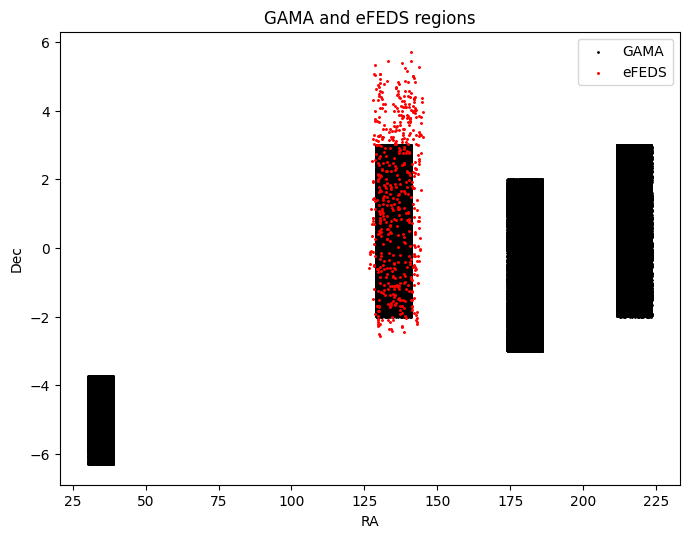

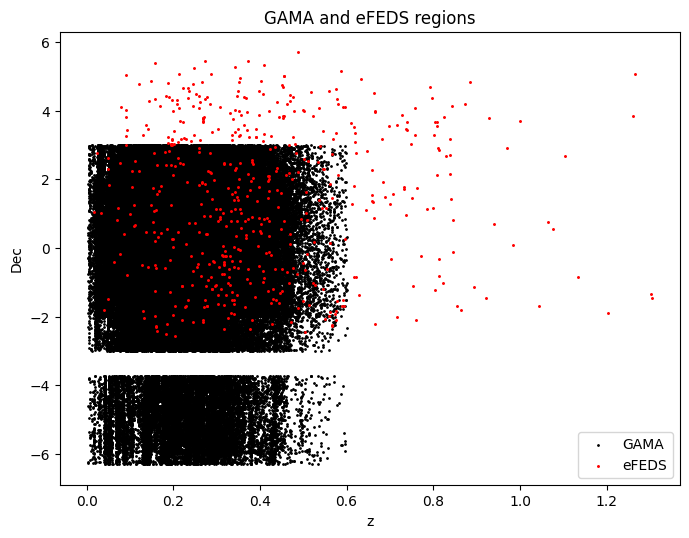

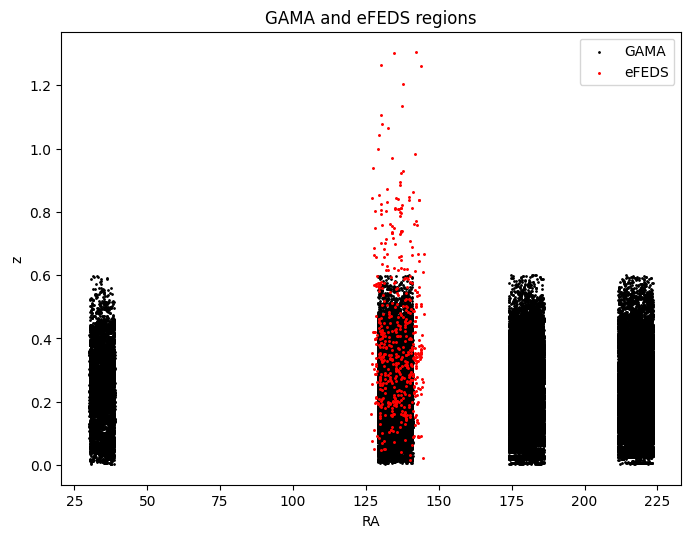

In [72]:
# plot the locations of the data: gama and efeds
plt.figure(figsize=(8,6),dpi=100)
plt.scatter(gamagals['RA'],gamagals['Dec'],c='black',s=1)
plt.scatter(efeds['RAJ2000'],efeds['DEJ2000'],c='red',s=1.25)
plt.title('GAMA and eFEDS regions')
plt.xlabel('RA')
plt.ylabel('Dec')
plt.legend(['GAMA','eFEDS'])
filename = "/suphys/fscu5535/python_scripts/figures/GAMAeFEDSRADec.png"
plt.savefig(filename, bbox_inches='tight', pad_inches=0.3, dpi = 250)

plt.figure(figsize=(8,6),dpi=100)
plt.scatter(gamagals['Z'],gamagals['Dec'],c='black',s=1)
plt.scatter(efeds['zBest'],efeds['DEJ2000'],c='red',s=1.25)
plt.title('GAMA and eFEDS regions')
plt.xlabel('z')
plt.ylabel('Dec')
plt.legend(['GAMA','eFEDS'])
filename = "/suphys/fscu5535/python_scripts/figures/GAMAeFEDSZDec.png"
plt.savefig(filename, bbox_inches='tight', pad_inches=0.3, dpi = 250)

plt.figure(figsize=(8,6),dpi=100)
plt.scatter(gamagals['RA'],gamagals['Z'],c='black',s=1)
plt.scatter(efeds['RAJ2000'],efeds['zBest'],c='red',s=1.25)
plt.title('GAMA and eFEDS regions')
plt.xlabel('RA')
plt.ylabel('z')
plt.legend(['GAMA','eFEDS'])
filename = "/suphys/fscu5535/python_scripts/figures/GAMAeFEDSRAZ.png"
plt.savefig(filename, bbox_inches='tight', pad_inches=0.3, dpi = 250)


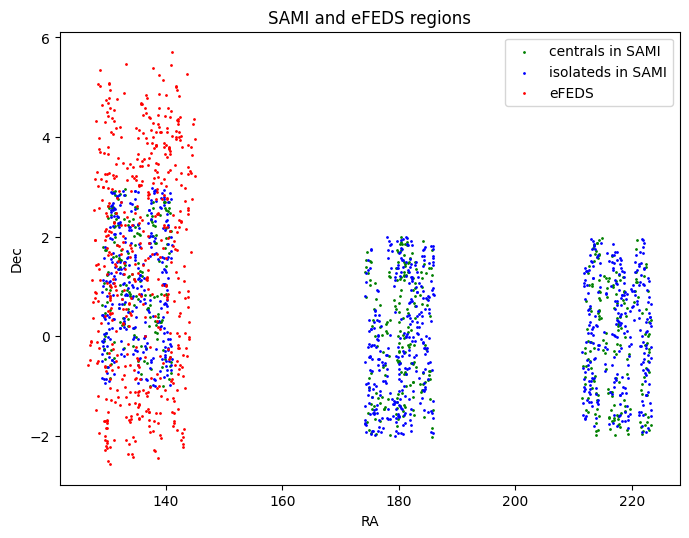

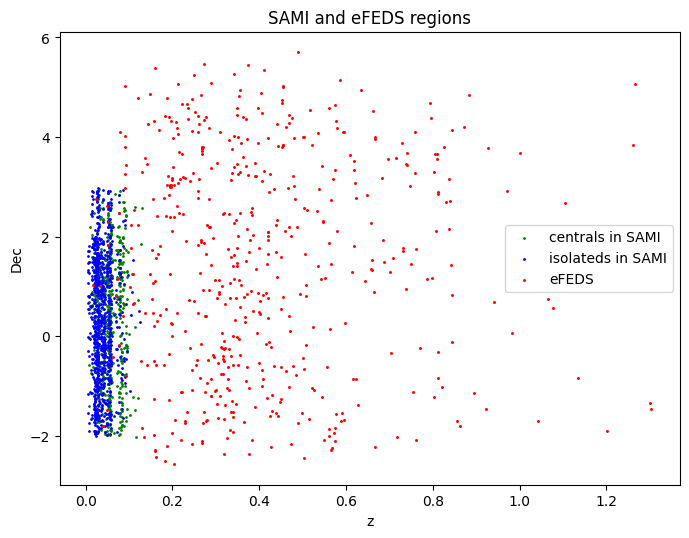

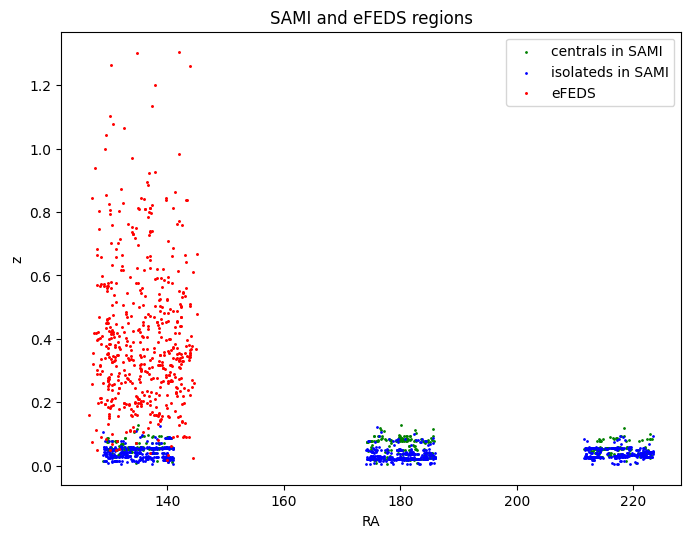

In [73]:
# plt centrals/isolateds and efeds
plt.figure(figsize=(8,6),dpi=100)
plt.scatter(data['IterCenRA'],data['IterCenDec'],c='green',s=1)
plt.scatter(isolateds['RA'],isolateds['Dec'],c='blue',s=1)
plt.scatter(efeds['RAJ2000'],efeds['DEJ2000'],c='red',s=1)
plt.title('SAMI and eFEDS regions')
plt.xlabel('RA')
plt.ylabel('Dec')
plt.legend(['centrals in SAMI','isolateds in SAMI','eFEDS'])
filename = "/suphys/fscu5535/python_scripts/figures/mydataeFEDSRADec.png"
plt.savefig(filename, bbox_inches='tight', pad_inches=0.3, dpi = 250)

plt.figure(figsize=(8,6),dpi=100)
plt.scatter(data['IterCenZ'],data['IterCenDec'],c='green',s=1)
plt.scatter(isolateds['Z'],isolateds['Dec'],c='blue',s=1)
plt.scatter(efeds['zBest'],efeds['DEJ2000'],c='red',s=1.25)
plt.title('SAMI and eFEDS regions')
plt.xlabel('z')
plt.ylabel('Dec')
plt.legend(['centrals in SAMI','isolateds in SAMI','eFEDS'])
filename = "/suphys/fscu5535/python_scripts/figures/mydataeFEDSZDec.png"
plt.savefig(filename, bbox_inches='tight', pad_inches=0.3, dpi = 250)

plt.figure(figsize=(8,6),dpi=100)
plt.scatter(data['IterCenRA'],data['IterCenZ'],c='green',s=1)
plt.scatter(isolateds['RA'],isolateds['Z'],c='blue',s=1)
plt.scatter(efeds['RAJ2000'],efeds['zBest'],c='red',s=1.25)
plt.title('SAMI and eFEDS regions')
plt.xlabel('RA')
plt.ylabel('z')
plt.legend(['centrals in SAMI','isolateds in SAMI','eFEDS'])
filename = "/suphys/fscu5535/python_scripts/figures/mydataeFEDSRAZ.png"
plt.savefig(filename, bbox_inches='tight', pad_inches=0.3, dpi = 250)

In [3]:
# matching eFEDS and GAMA
matchingAngle = 500/3600
matchingRedshift = 0.02

gamacentralRA = list()
gamacentralDec = list()
gamacentralZ = list()
gamaGroupID = list()
gamaMassA = list()
gamaNfof = list()
gamaRgap = list()

efedscentralRA = list()
efedscentralDec = list()
efedscentralZ = list()
efedscentralLbol500 = list()
efedscentralL500 = list()
efedsID = list()

xraycount = 0

for i in range(len(efedslum)):
    
    if ((128.85 < efedslum['RAJ2000'][i] < 140.15)
        and (-1.95 < efedslum['DEJ2000'][i] < 3.05)
        and (efedslum['z'][i] < 0.55)):
        
        xraycount += 1
      
        for j in range(len(gamagroups)):
            if (np.sqrt((efedslum['RAJ2000'][i] - gamagroups['IterCenRA'][j])**2
                        + (efedslum['DEJ2000'][i] - gamagroups['IterCenDec'][j])**2) < matchingAngle
                and abs(efedslum['z'][i] - gamagroups['Zfof'][j]) < matchingRedshift
               and gamagroups['IterCenRA'][j] not in gamacentralRA):

                gamacentralRA.append(gamagroups['IterCenRA'][j])
                gamacentralDec.append(gamagroups['IterCenDec'][j])
                gamacentralZ.append(gamagroups['Zfof'][j])
                gamaGroupID.append(gamagroups['GroupID'][j])
                gamaMassA.append(gamagroups['MassA'][j])
                gamaNfof.append(gamagroups['Nfof'][j])
                gamaRgap.append(gamagroups['Rgap'][j])

                efedscentralRA.append(efedslum['RAJ2000'][i])
                efedscentralDec.append(efedslum['DEJ2000'][i])
                efedscentralZ.append(efedslum['z'][i])
                efedscentralLbol500.append(efedslum['Lbol500kpc'][i])
                efedscentralL500.append(efedslum['L500kpc'][i])
                efedsID.append(efedslum['ID'][i])

                break
                
print(xraycount, "xray sources in actual G09 field")            
print(len(gamaGroupID),"matches found.")
print("Fraction matched:", len(gamaGroupID)*100/xraycount)

matchedGals = Table()
matchedGals['gamaRA'] = gamacentralRA
matchedGals['gamaDec'] = gamacentralDec
matchedGals['gamaZ'] = gamacentralZ
matchedGals['GroupID'] = gamaGroupID
matchedGals['MassA'] = gamaMassA
matchedGals['Nfof'] = gamaNfof
matchedGals['Rgap'] = gamaRgap
matchedGals['efedsRA'] = efedscentralRA
matchedGals['efedsDec'] = efedscentralDec
matchedGals ['efedsZ'] = efedscentralZ
matchedGals['Lbol500kpc'] = efedscentralLbol500
matchedGals['L500kpc'] = efedscentralL500
matchedGals['efedsID'] = efedsID


192 xray sources in actual G09 field
153 matches found.
Fraction matched: 79.6875


In [4]:
# see how many match with my data set
count = 0
for i in range(len(data)):
    if data['GroupID'][i] in matchedGals['GroupID']:
        count += 1
        
print(count)

9


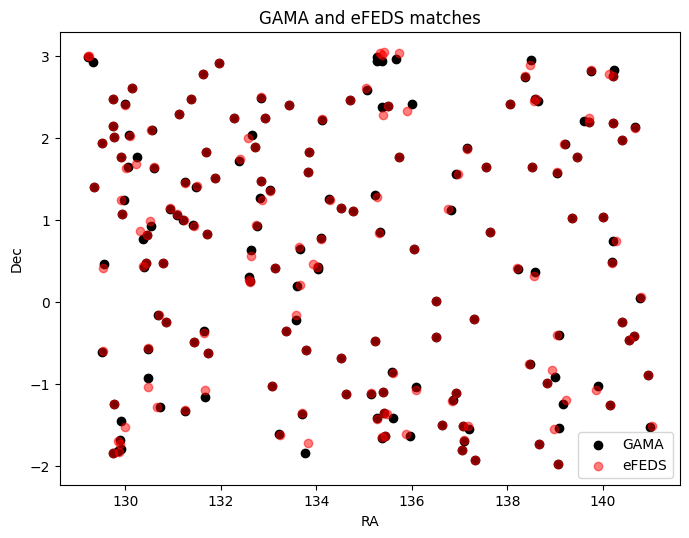

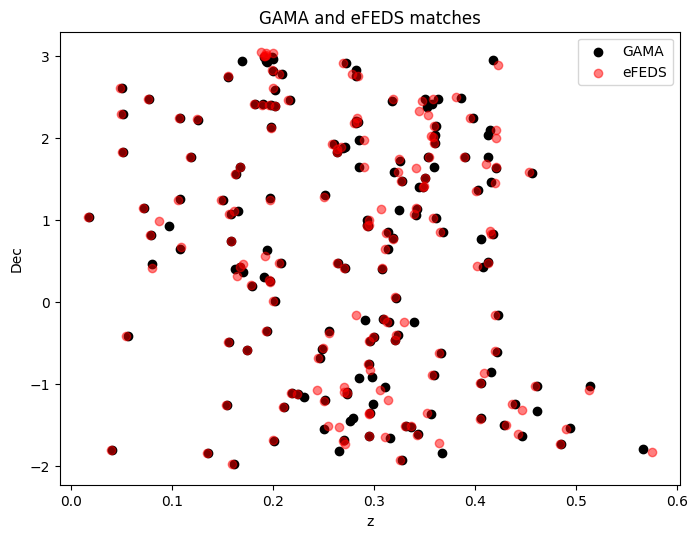

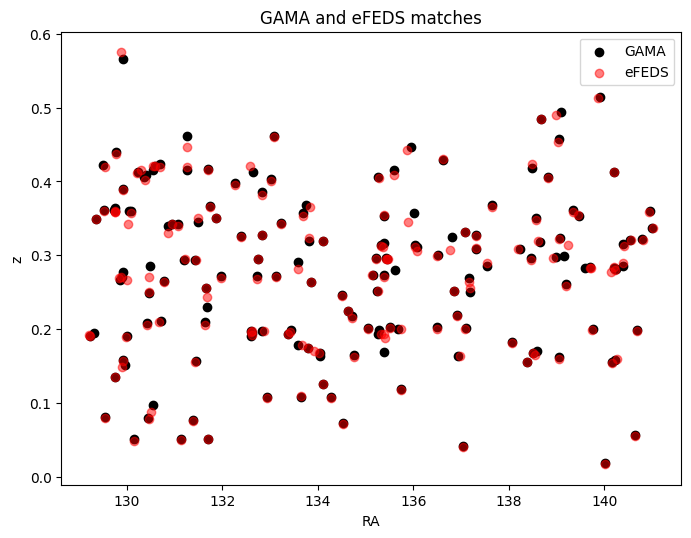

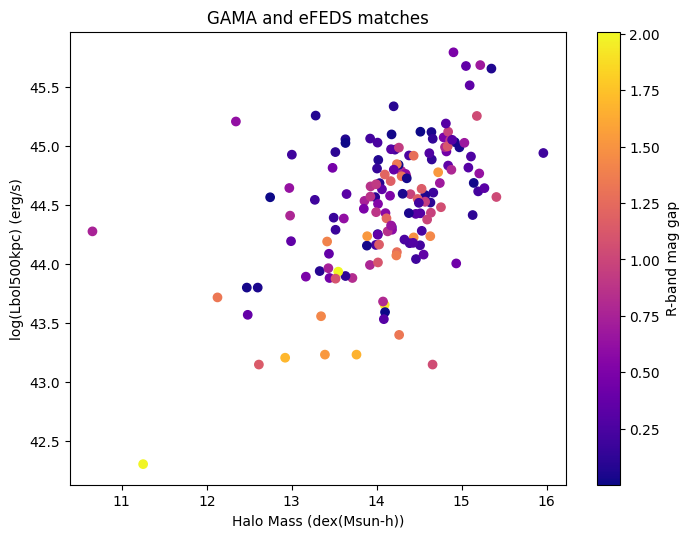

In [12]:
# plot the locations of the matches
plt.figure(figsize=(8,6),dpi=100)
plt.scatter(gamacentralRA,gamacentralDec,c='black')
plt.scatter(efedscentralRA,efedscentralDec,c='red',alpha=0.5)
plt.title('GAMA and eFEDS matches')
plt.xlabel('RA')
plt.ylabel('Dec')
plt.legend(['GAMA','eFEDS'])
filename = "/suphys/fscu5535/python_scripts/figures/GAMAeFEDSRADecMatches2.0.png"
plt.savefig(filename, bbox_inches='tight', pad_inches=0.3, dpi = 250)

plt.figure(figsize=(8,6),dpi=100)
plt.scatter(gamacentralZ,gamacentralDec,c='black')
plt.scatter(efedscentralZ,efedscentralDec,c='red',alpha=0.5)
plt.title('GAMA and eFEDS matches')
plt.xlabel('z')
plt.ylabel('Dec')
plt.legend(['GAMA','eFEDS'])
filename = "/suphys/fscu5535/python_scripts/figures/GAMAeFEDSZDecMatches2.0.png"
plt.savefig(filename, bbox_inches='tight', pad_inches=0.3, dpi = 250)

plt.figure(figsize=(8,6),dpi=100)
plt.scatter(gamacentralRA,gamacentralZ,c='black')
plt.scatter(efedscentralRA,efedscentralZ,c='red',alpha=0.5)
plt.title('GAMA and eFEDS matches')
plt.xlabel('RA')
plt.ylabel('z')
plt.legend(['GAMA','eFEDS'])
filename = "/suphys/fscu5535/python_scripts/figures/GAMAeFEDSRAZMatches2.0.png"
plt.savefig(filename, bbox_inches='tight', pad_inches=0.3, dpi = 250)

plt.figure(figsize=(8,6),dpi=100)
plt.scatter(np.log10(gamaMassA),np.log10(matchedGals['Lbol500kpc']*10e43),c=gamaRgap,cmap='plasma')
plt.title('GAMA and eFEDS matches')
plt.xlabel('Halo Mass (dex(Msun-h))')
plt.ylabel('log(Lbol500kpc) (erg/s)')
cbar = plt.colorbar()
cbar.set_label('R-band mag gap')
filename = "/suphys/fscu5535/python_scripts/figures/GAMAeFEDSHaloMassLxMatches2.0.png"
plt.savefig(filename, bbox_inches='tight', pad_inches=0.3, dpi = 250)



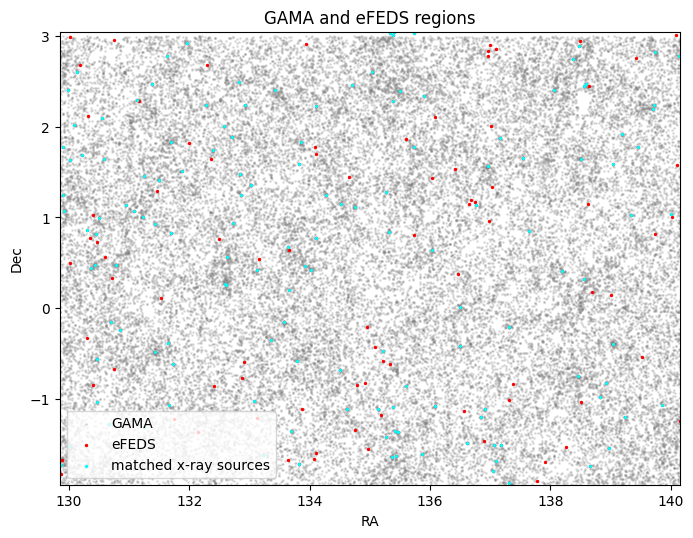

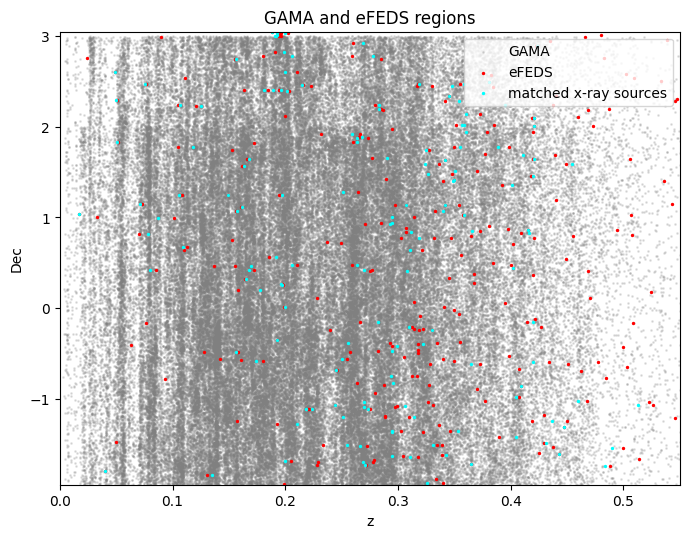

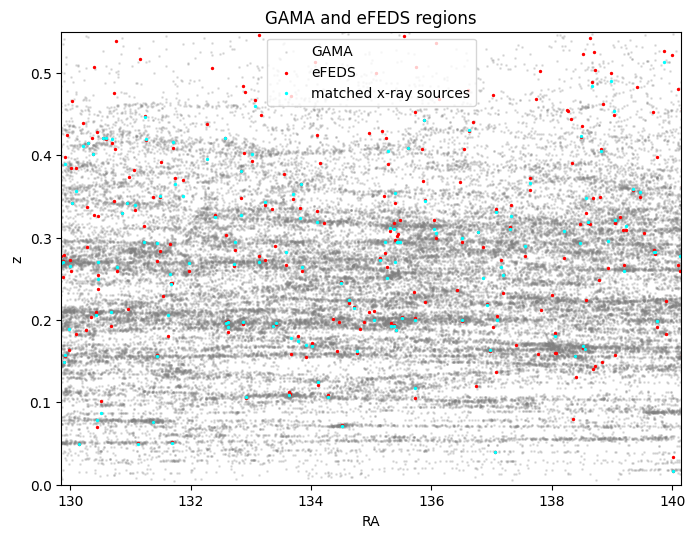

In [18]:
# plot the locations of the data: gama and efeds
plt.figure(figsize=(8,6),dpi=100)
plt.scatter(gamagals['RA'],gamagals['Dec'],c='grey',s=1,alpha=0.2)
plt.scatter(efeds['RAJ2000'],efeds['DEJ2000'],c='red',s=2)
plt.scatter(matchedGals['efedsRA'],matchedGals['efedsDec'],s=2,c='cyan')
plt.title('GAMA and eFEDS regions')
plt.xlabel('RA')
plt.xlim(129.85,140.15)
plt.ylim(-1.95,3.05)
plt.ylabel('Dec')
plt.legend(['GAMA','eFEDS','matched x-ray sources'])
filename = "/suphys/fscu5535/python_scripts/figures/GAMAeFEDSRADec2.0.png"
plt.savefig(filename, bbox_inches='tight', pad_inches=0.3, dpi = 250)

plt.figure(figsize=(8,6),dpi=100)
plt.scatter(gamagals['Z'],gamagals['Dec'],c='grey',s=1,alpha=0.2)
plt.scatter(efeds['zBest'],efeds['DEJ2000'],c='red',s=2)
plt.scatter(matchedGals['efedsZ'],matchedGals['efedsDec'],s=2,c='cyan')
plt.title('GAMA and eFEDS regions')
plt.xlabel('z')
plt.ylabel('Dec')
plt.xlim(0,0.55)
plt.ylim(-1.95,3.05)
plt.legend(['GAMA','eFEDS','matched x-ray sources'])
filename = "/suphys/fscu5535/python_scripts/figures/GAMAeFEDSZDec2.0.png"
plt.savefig(filename, bbox_inches='tight', pad_inches=0.3, dpi = 250)

plt.figure(figsize=(8,6),dpi=100)
plt.scatter(gamagals['RA'],gamagals['Z'],c='grey',s=1,alpha=0.2)
plt.scatter(efeds['RAJ2000'],efeds['zBest'],c='red',s=2)
plt.scatter(matchedGals['efedsRA'],matchedGals['efedsZ'],s=2,c='cyan')
plt.title('GAMA and eFEDS regions')
plt.xlabel('RA')
plt.xlim(129.85,140.15)
plt.ylim(0,0.55)
plt.ylabel('z')
plt.legend(['GAMA','eFEDS','matched x-ray sources'])
filename = "/suphys/fscu5535/python_scripts/figures/GAMAeFEDSRAZ2.0.png"
plt.savefig(filename, bbox_inches='tight', pad_inches=0.3, dpi = 250)


In [5]:
# matching eFEDS to my data
matchingAngle = 50/3600
matchingRedshift = 0.005
samicentralID = list()
samicentralRA = list()
samicentralDec = list()
samicentralZ = list()
samigamaGroupID = list()
samiMassGap = list()
samiHaloMass = list()
samiSpin = list()
efedscentralRA = list()
efedscentralDec = list()
efedscentralZ = list()
efedscentralL500 = list()
efedscentralLbol500 = []

samiisolatedID = list()
samiisolatedRA = list()
samiisolatedDec = list()
samiisolatedZ = list()
samiisolatedspin = []
efedsisolatedRA = list()
efedsisolatedDec = list()
efedsisolatedZ = list()
efedsisolatedL500 = list()
efedsisolatedLbol500 = []
efedsID = []
insami = []


for i in range(len(matchedGals)):
    found = False
    for j in range(len(data)):
        if matchedGals['GroupID'][i] == data['GroupID'][j]:
            
            found = True
            samicentralID.append(data['m1_CATAID'][j])
            samicentralRA.append(data['IterCenRA'][j])
            samicentralDec.append(data['IterCenDec'][j])
            samicentralZ.append(data['Zfof'][j])
            samigamaGroupID.append(data['GroupID'][j])
            samiMassGap.append(data['m1-IntMean'][j])
            samiSpin.append(data['LAMBDAR_RE_SEEING'][j])
            samiHaloMass.append(data['log(MassA)'][j])
            efedscentralRA.append(matchedGals['efedsRA'][i])
            efedscentralDec.append(matchedGals['efedsDec'][i])
            efedscentralZ.append(matchedGals['efedsZ'][i])
            efedscentralL500.append(matchedGals['L500kpc'][i])
            efedscentralLbol500.append(matchedGals['Lbol500kpc'][i])
            efedsID.append(matchedGals['efedsID'][i])
            
            insami.append(1)
            break
        if found == False:          
            insami.append(0)
    
    for k in range(len(isolateds)):
        if (np.sqrt((efeds['RAJ2000'][i] - isolateds['RA'][k])**2
                    + (efeds['DEJ2000'][i] - isolateds['Dec'][k])**2) < matchingAngle
            and abs(efeds['zBest'][i] - isolateds['Z'][k]) < matchingRedshift):
            
            samiisolatedID.append(isolateds['CATAID'][k])
            samiisolatedRA.append(isolateds['RA'][k])
            samiisolatedDec.append(isolateds['Dec'][k])
            samiisolatedZ.append(isolateds['Z'][k])
            samiisolatedspin.append(isolateds['LAMBDAR_RE_SEEING'][k])
            efedsisolatedRA.append(matchedGals['efedsRA'][i])
            efedsisolatedDec.append(matchedGals['efedsDec'][i])
            efedsisolatedZ.append(matchedGals['efedsZ'][i])
            efedsisolatedL500.append(matchedGals['L500kpc'][i])
            efedsisolatedLbol500.append(matchedGals['Lbol500kpc'][i])
            
print(len(samicentralID),"central gama matches found")
print(len(efedscentralRA),"central efeds matches found")
print()
print(len(samiisolatedID),"isolated gama matches found")
print(len(efedsisolatedRA),"isolated efeds matches found")



9 central gama matches found
9 central efeds matches found

0 isolated gama matches found
0 isolated efeds matches found


In [34]:
efedsSAMImatches = Table()
efedsSAMImatches['efedsID'] = efedsID
efedsSAMImatches['LAMBDAR_RE_SEEING'] = samiSpin
efedsSAMImatches['m1-Intmean'] = samiMassGap
efedsSAMImatches['m1_CATAID'] = samicentralID

efedsSAMImatches.info()

# left join
efedsGamamatches = Table.read('/suphys/fscu5535/python_scripts/mod_data/efedsGamamatches500arcs0.02z.fits')
print(efedsGamamatches['Lbol500kpc'])
efedsSAMImatches = join(efedsSAMImatches,efedsGamamatches,keys='efedsID',join_type='left')

#efedsSAMImatches.info()

<Table length=10>
       name        dtype 
----------------- -------
          efedsID   str22
LAMBDAR_RE_SEEING float32
       m1-Intmean float32
        m1_CATAID   int64
      Lbol500kpc      
----------------------
             1.143e+45
1.1590000000000001e+45
 6.570000000000001e+44
              9.01e+44
3.4300000000000006e+44
               2.5e+43
1.8030000000000003e+45
 5.860000000000001e+44
1.2570000000000002e+45
              6.17e+44
                   ...
             1.154e+45
             2.177e+45
1.7700000000000003e+44
 7.800000000000001e+43
 7.030000000000001e+44
              6.31e+44
3.2810000000000003e+45
3.4000000000000006e+43
1.6100000000000003e+44
6.0000000000000005e+44
1.3250000000000001e+45
Length = 152 rows


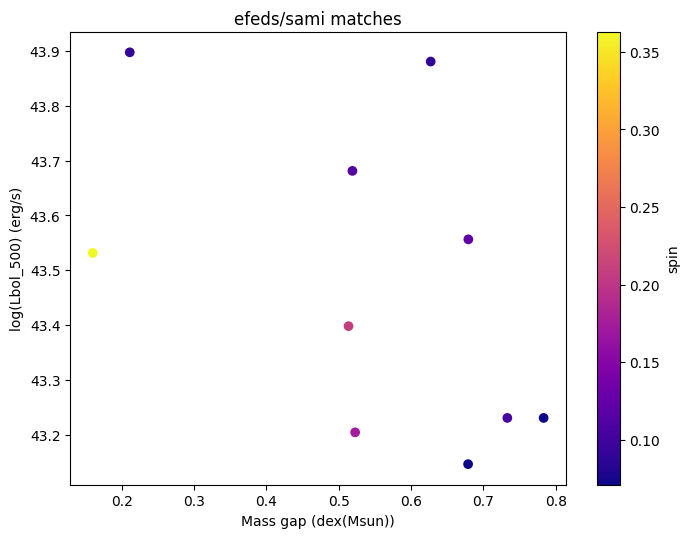

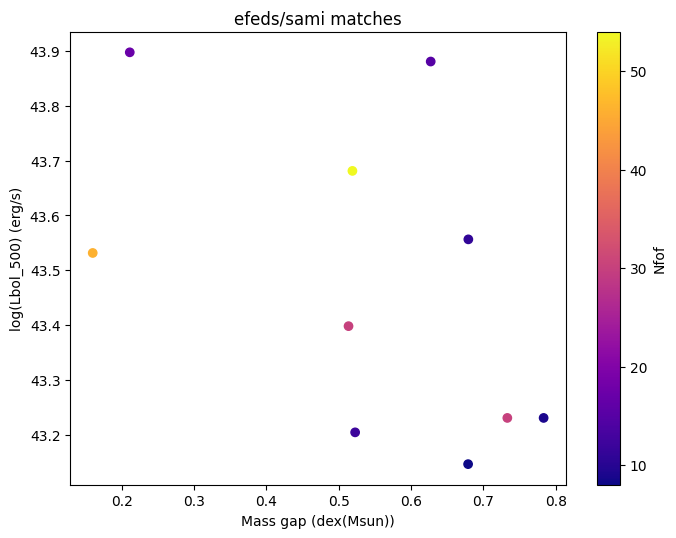

In [40]:
# plots for sami matches
plt.figure(figsize=(8,6),dpi=100)
plt.scatter(efedsSAMImatches['m1-Intmean'],np.log10(efedsSAMImatches['Lbol500kpc']),c=efedsSAMImatches['LAMBDAR_RE_SEEING'],cmap='plasma')
plt.xlabel('Mass gap (dex(Msun))')
plt.ylabel('log(Lbol_500) (erg/s)')
cbar = plt.colorbar()
cbar.set_label('spin')
plt.title('efeds/sami matches')
filename = "/suphys/fscu5535/python_scripts/figures/efedsSAMILbolMassgapSpin.png"
plt.savefig(filename, bbox_inches='tight', pad_inches=0.3, dpi = 250)

plt.figure(figsize=(8,6),dpi=100)
plt.scatter(efedsSAMImatches['m1-Intmean'],np.log10(efedsSAMImatches['Lbol500kpc']),c=efedsSAMImatches['Nfof'],cmap='plasma')
plt.xlabel('Mass gap (dex(Msun))')
plt.ylabel('log(Lbol_500) (erg/s)')
cbar = plt.colorbar()
cbar.set_label('Nfof')
plt.title('efeds/sami matches')
filename = "/suphys/fscu5535/python_scripts/figures/efedsSAMILbolMassgapNfof.png"
plt.savefig(filename, bbox_inches='tight', pad_inches=0.3, dpi = 250)

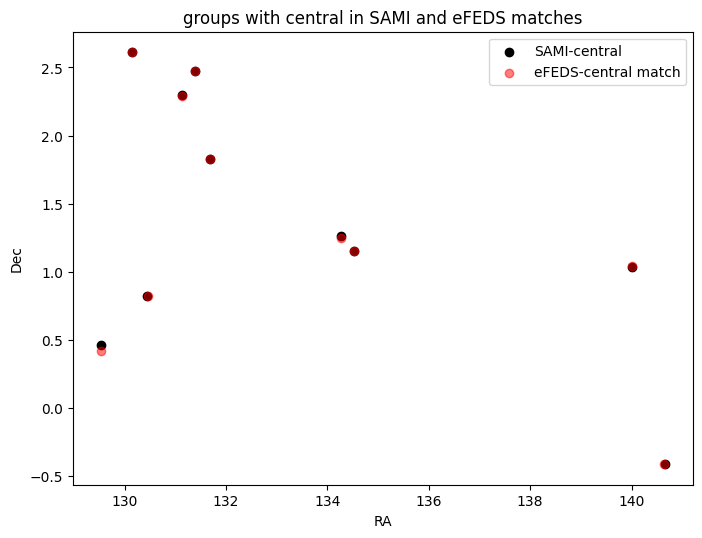

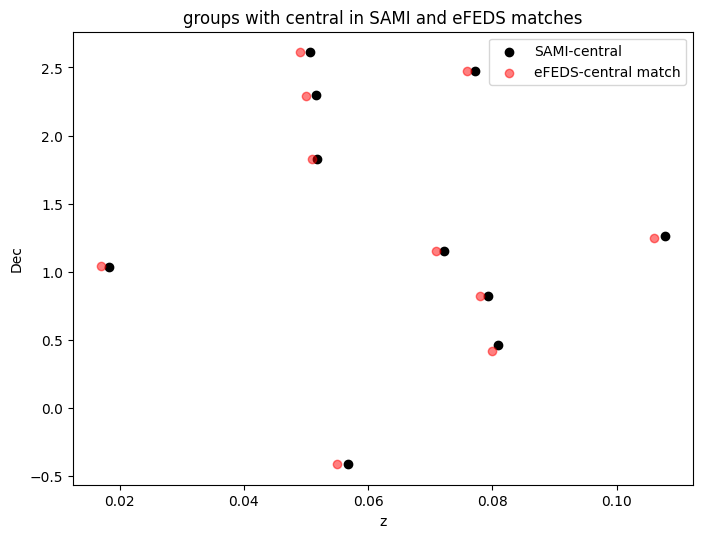

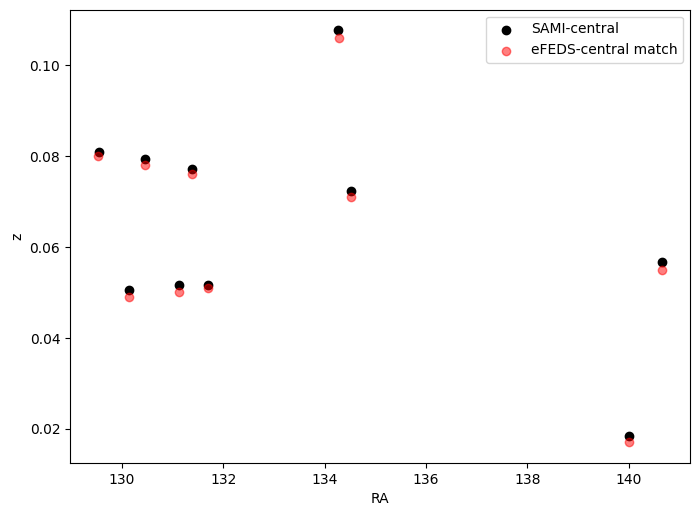

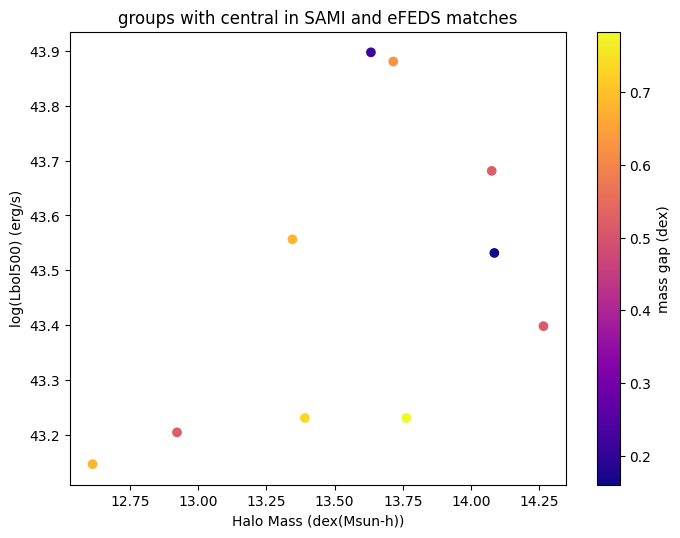

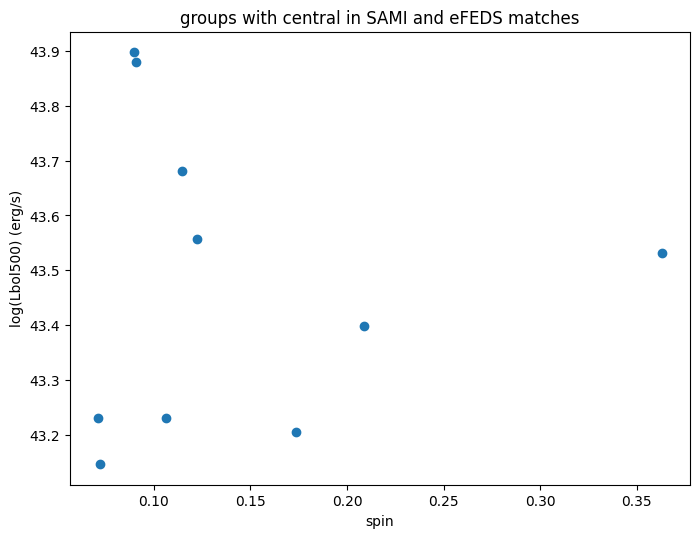

In [15]:
# plot the locations of the matches
plt.figure(figsize=(8,6),dpi=100)
plt.scatter(samicentralRA,samicentralDec,c='black')
plt.scatter(efedscentralRA,efedscentralDec,c='red',alpha=0.5)
plt.scatter(samiisolatedRA,samiisolatedDec,c='grey')
plt.scatter(efedsisolatedRA,efedsisolatedDec,c='green',alpha=0.5)
plt.title('groups with central in SAMI and eFEDS matches')
plt.xlabel('RA')
plt.ylabel('Dec')
plt.legend(['SAMI-central','eFEDS-central match'])
filename = "/suphys/fscu5535/python_scripts/figures/SAMIeFEDSRADecMatches2.0.png"
plt.savefig(filename, bbox_inches='tight', pad_inches=0.3, dpi = 250)

plt.figure(figsize=(8,6),dpi=100)
plt.scatter(samicentralZ,samicentralDec,c='black')
plt.scatter(efedscentralZ,efedscentralDec,c='red',alpha=0.5)
plt.scatter(samiisolatedZ,samiisolatedDec,c='grey')
plt.scatter(efedsisolatedZ,efedsisolatedDec,c='green',alpha=0.5)
plt.title('groups with central in SAMI and eFEDS matches')
plt.xlabel('z')
plt.ylabel('Dec')
plt.legend(['SAMI-central','eFEDS-central match'])
filename = "/suphys/fscu5535/python_scripts/figures/SAMIeFEDSZDecMatches2.0.png"
plt.savefig(filename, bbox_inches='tight', pad_inches=0.3, dpi = 250)

plt.figure(figsize=(8,6),dpi=100)
plt.scatter(samicentralRA,samicentralZ,c='black')
plt.scatter(efedscentralRA,efedscentralZ,c='red',alpha=0.5)
plt.scatter(samiisolatedRA,samiisolatedZ,c='grey')
plt.scatter(efedsisolatedRA,efedsisolatedZ,c='green',alpha=0.5)
plt.legend(['SAMI-central','eFEDS-central match'])
plt.xlabel('RA')
plt.ylabel('z')
plt.legend(['SAMI-central','eFEDS-central match'])
filename = "/suphys/fscu5535/python_scripts/figures/SAMIeFEDSRAZMatches2.0.png"
plt.savefig(filename, bbox_inches='tight', pad_inches=0.3, dpi = 250)

plt.figure(figsize=(8,6),dpi=100)
plt.scatter(samiHaloMass,np.log10(np.asarray(efedscentralLbol500)*10e43),c=samiMassGap,cmap='plasma')
plt.title('groups with central in SAMI and eFEDS matches')
plt.xlabel('Halo Mass (dex(Msun-h))')
plt.ylabel('log(Lbol500) (erg/s)')
cbar = plt.colorbar()
cbar.set_label('mass gap (dex)')
filename = "/suphys/fscu5535/python_scripts/figures/SAMIeFEDSHaloMassLxMatches2.0.png"
plt.savefig(filename, bbox_inches='tight', pad_inches=0.3, dpi = 250)

plt.figure(figsize=(8,6),dpi=100)
plt.scatter(samiSpin,np.log10(np.asarray(efedscentralLbol500)*10e43))
plt.title('groups with central in SAMI and eFEDS matches')
plt.xlabel('spin')
plt.ylabel('log(Lbol500) (erg/s)')
filename = "/suphys/fscu5535/python_scripts/figures/SAMIeFEDSSpinLxMatches2.0.png"
plt.savefig(filename, bbox_inches='tight', pad_inches=0.3, dpi = 250)

Text(0, 0.5, 'Matches')

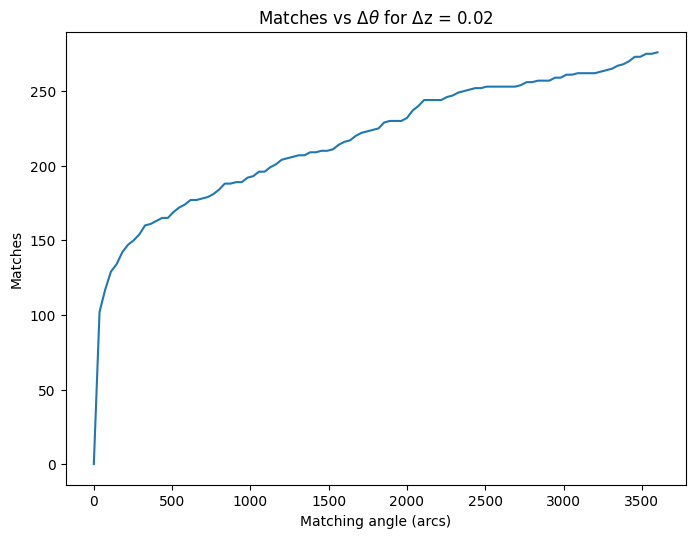

In [8]:
# try to optimise matching angle (and redshift??). look at matches vs delta theta.

# matching eFEDS and GAMA
matchingAngle = np.linspace(1/3600,3600/3600,100)

gamacentralRA = []
gamacentralDec = []
gamacentralZ = []
gamaGroupID = []
gamaMassA = []
gamaNfof = []
gamaRgap = []

efedscentralRA = []
efedscentralDec = []
efedscentralZ = []
efedscentralLx = []

matches = []
matchingRedshift = 0.02
    

for k in range(len(matchingAngle)):

    matchedIDs = []
    matchesfound = 0

    for i in range(len(efeds)):
        for j in range(len(gamagroups)):
            if (np.sqrt((efedslum['RAJ2000'][i] - gamagroups['IterCenRA'][j])**2
                        + (efedslum['DEJ2000'][i] - gamagroups['IterCenDec'][j])**2) < matchingAngle[k]
                and abs(efedslum['z'][i] - gamagroups['Zfof'][j]) < matchingRedshift
                and gamagroups['GroupID'][j] not in matchedIDs):

                matchedIDs.append(gamagroups['GroupID'][j])
                matchesfound += 1

                break
                
    matches.append(matchesfound)
    
    
plt.figure(figsize=(8,6),dpi=100)
plt.plot(matchingAngle*3600,matches)
plt.title(r"Matches vs $\Delta\theta$ for $\Delta$z = 0.02")
plt.xlabel("Matching angle (arcs)")
plt.ylabel("Matches")
                
            

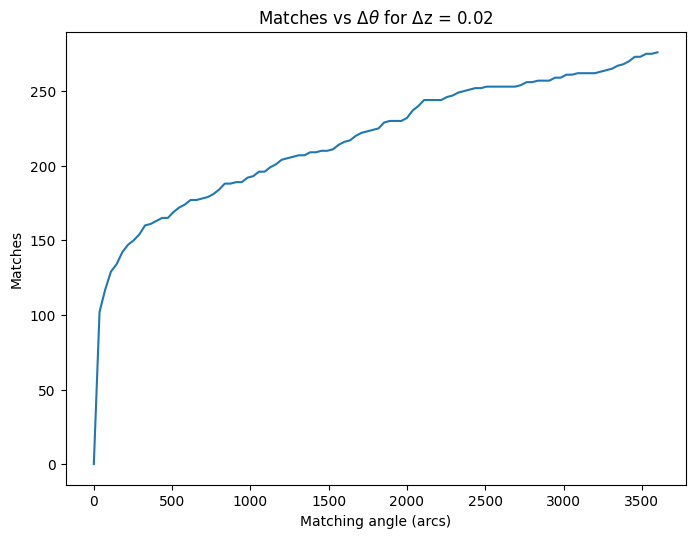

In [9]:
plt.figure(figsize=(8,6),dpi=100)
plt.plot(matchingAngle*3600,matches)
plt.title(r"Matches vs $\Delta\theta$ for $\Delta$z = 0.02")
plt.xlabel("Matching angle (arcs)")
plt.ylabel("Matches")               
filename = "/suphys/fscu5535/python_scripts/figures/MatchesvsMatchinganglez0.02.png"
plt.savefig(filename, bbox_inches='tight', pad_inches=0.3, dpi = 250)


Text(0, 0.5, 'Matches')

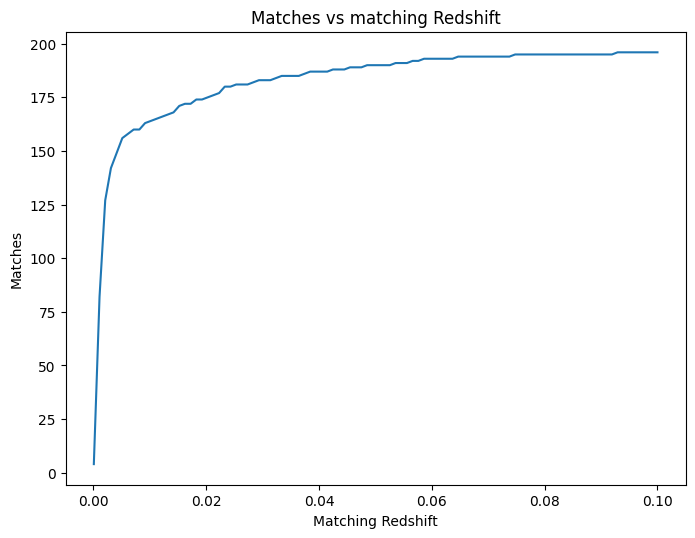

In [6]:
# same thing but for redshift

# matching eFEDS and GAMA
matchingRedshift = np.linspace(0.0001,0.1,100)

gamacentralRA = []
gamacentralDec = []
gamacentralZ = []
gamaGroupID = []
gamaMassA = []
gamaNfof = []
gamaRgap = []

efedscentralRA = []
efedscentralDec = []
efedscentralZ = []
efedscentralLx = []


matches = []    
matchingAngle =  500/3600 

for k in range(len(matchingRedshift)):




#     gamacentralRA.append([])
#     gamacentralDec.append([])
#     gamacentralZ.append([])
#     gamaGroupID.append([])
#     gamaMassA.append([])
#     gamaNfof.append([])
#     gamaRgap.append([])

#     efedscentralRA.append([])
#     efedscentralDec.append([])
#     efedscentralZ.append([])
#     efedscentralLx.append([])
    matchesfound = 0
    GroupIDs = []

    for i in range(len(efeds)):
        for j in range(len(gamagroups)):
            if (np.sqrt((efedslum['RAJ2000'][i] - gamagroups['IterCenRA'][j])**2
                        + (efedslum['DEJ2000'][i] - gamagroups['IterCenDec'][j])**2) < matchingAngle
                and abs(efedslum['z'][i] - gamagroups['Zfof'][j]) < matchingRedshift[k]
               and gamagroups['GroupID'][j] not in matches):

#                 gamacentralRA.append(gamagroups['IterCenRA'][k][j])
#                 gamacentralDec.append(gamagroups['IterCenDec'][k][j])
#                 gamacentralZ.append(gamagroups['Zfof'][k][j])
#                 gamaGroupID.append(gamagroups['GroupID'][k][j])
#                 gamaMassA.append(gamagroups['MassA'][k][j])
#                 gamaNfof.append(gamagroups['Nfof'][k][j])
#                 gamaRgap.append(gamagroups['Rgap'][k][j])

#                 efedscentralRA.append(efeds['RAJ2000'][k][i])
#                 efedscentralDec.append(efeds['DEJ2000'][k][i])
#                 efedscentralZ.append(efeds['zBest'][k][i])
#                 efedscentralLx.append(efeds['MLFlux'][k][i])
                GroupIDs.append(gamagroups['GroupID'][j])
                matchesfound += 1

                break
                
    matches.append(matchesfound)
    
    
plt.figure(figsize=(8,6),dpi=100)
plt.plot(matchingRedshift,matches)
plt.title("Matches vs matching Redshift")
plt.xlabel("Matching Redshift")
plt.ylabel("Matches")
                
            

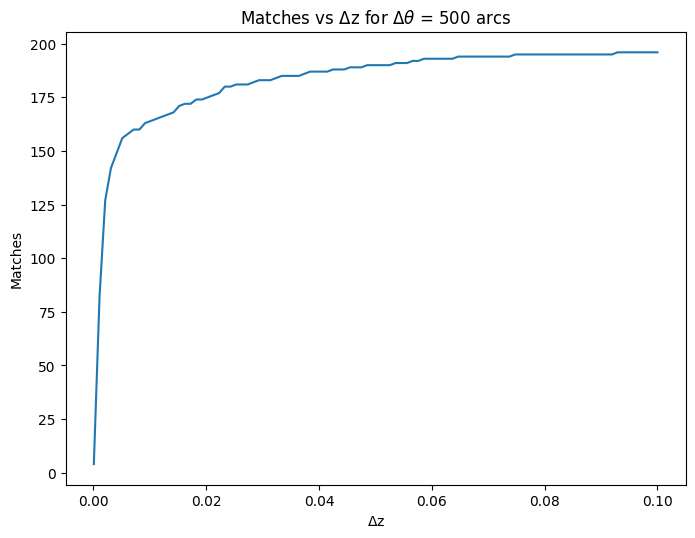

In [7]:
plt.figure(figsize=(8,6),dpi=100)
plt.plot(matchingRedshift,matches)
plt.title(r"Matches vs $\Delta$z for $\Delta\theta$ = 500 arcs")
plt.xlabel("$\Delta$z")
plt.ylabel("Matches")
filename = "/suphys/fscu5535/python_scripts/figures/matchesvsZfor500arcstheta.png"
plt.savefig(filename, bbox_inches='tight', pad_inches=0.3, dpi = 250)